# Importing Lib's

In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve
from sklearn.pipeline import Pipeline

In [2]:
rng = np.random.RandomState(123)

# Importing Data

In [3]:
features = pd.read_csv('data.csv')
gt = sio.loadmat('Pavia_gt.mat')

In [4]:
labels = gt['pavia_gt']
y = labels[:,226:].ravel()
y = y[y!=0]
features.shape, y.shape

((103417, 13), (103417,))

In [5]:
labels_names =['Water', 'Trees', 'Asphalt', 'Self-Blocking Bricks', 'Bitumen', 
               'Tiles', 'Shadows', 'Meadows', 'Bare Soil']

# Some Exploration

In [6]:
features.head()

,mean,std,variance,skew,kurtosis,q25,q75,low,peak,iqr,pwr_mean,pwr_entr,rms
0,833.558824,45.282463,2070.803436,-1.271379,1.243844,805.75,862.75,685,891,57.0,4022.1372,1.524930,374.76944
1,817.598039,124.408188,15630.638808,-3.295761,13.253635,798.25,885.75,131,938,87.5,30359.5100,2.490841,834.96515
2,848.843137,89.595906,8106.905844,-2.115042,4.541311,826.50,903.00,493,943,76.5,15746.1050,2.156564,636.14780
3,958.225490,145.418187,21355.819938,-1.071936,0.219539,871.25,1066.75,579,1114,195.5,41479.5700,1.430939,1174.54440
4,1115.843137,150.532567,22884.410794,-0.880666,0.257709,1031.50,1245.50,685,1308,214.0,44448.5660,1.801792,1115.11700


In [7]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103417 entries, 0 to 103416
Data columns (total 13 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   mean      103417 non-null  float64
 1   std       103417 non-null  float64
 2   variance  103417 non-null  float64
 3   skew      103417 non-null  float64
 4   kurtosis  103417 non-null  float64
 5   q25       103417 non-null  float64
 6   q75       103417 non-null  float64
 7   low       103417 non-null  int64  
 8   peak      103417 non-null  int64  
 9   iqr       103417 non-null  float64
 10  pwr_mean  103417 non-null  float64
 11  pwr_entr  103417 non-null  float64
 12  rms       103417 non-null  float64
dtypes: float64(11), int64(2)
memory usage: 10.3 MB


In [8]:
print("Number of classes: ", len(np.unique(y)))

Number of classes:  9


In [9]:
print('Total per class:\n')
for i in range(1,10):
    print(labels_names[i-1]+' = '+str(np.sum(y==i)))

Total per class:

Water = 65278
Trees = 6503
Asphalt = 2880
Self-Blocking Bricks = 2140
Bitumen = 6549
Tiles = 7493
Shadows = 7287
Meadows = 3122
Bare Soil = 2165


### Feature dataset to numpy matrix 

In [10]:
X = features.to_numpy()

In [11]:
X.shape

(103417, 13)

# Applying Models

In [29]:
# importing metrics 
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, accuracy_score

## DECISION TREE

In [19]:
from sklearn.tree import DecisionTreeClassifier

In [20]:
DT_pipe = Pipeline([("scaler", StandardScaler()),
                    ("clf", DecisionTreeClassifier(random_state=rng))]) 

In [21]:
%%time
# configure the cross-validation procedure
cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=rng)

# metrics list
dt_acc = []
dt_F1_score = []
dt_roc_auc = []
dt_conf_matrix_list = []

for train_ix, test_ix in cv_outer.split(X, y):
    # split data

    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]
    # configure the cross-validation procedure
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=rng)

    # define search space
    param_grid = {'clf__criterion':['gini', 'entropy'],
                  'clf__max_depth': range(1,4),
                  'clf__max_features': ['auto', 'sqrt', 'log2'],
                  }

    # define search
    DT_gs = GridSearchCV(DT_pipe, param_grid, cv=cv_inner, n_jobs=-1)
    
    # execute search
    DT_gs.fit(X_train, y_train)
    
    # get the best performing model fit on the whole training set
    best_model = DT_gs.best_estimator_
    # evaluate model on the test set
    yhat = best_model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, yhat)
    
    # store the result
    dt_acc.append(accuracy_score(y_test, yhat))
    dt_F1_score.append(f1_score(y_test, yhat, average='micro'))
    dt_roc_auc.append(roc_auc_score(y_test, best_model.predict_proba(X_test), multi_class='ovr'))
    dt_conf_matrix_list.append(conf_matrix) 

Wall time: 1min


In [22]:
print('Mean accuracy:', np.mean(dt_acc))
print('Mean F1_score:', np.mean(dt_F1_score))
print('Mean Roc AUC:', np.mean(dt_roc_auc))

Mean accuracy: 0.8667434049483115
Mean F1_score: 0.8667434049483115
Mean Roc AUC: 0.9623557194912641


In [24]:
mean_cm = np.mean(dt_conf_matrix_list, axis = 0)

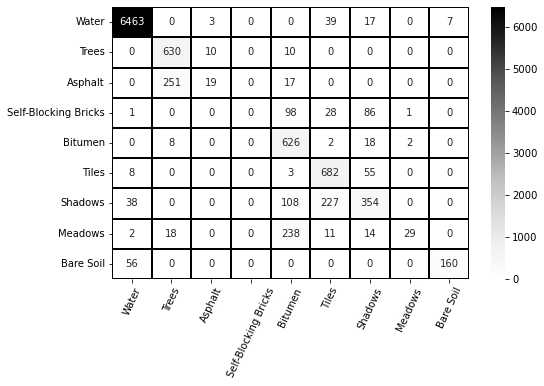

In [25]:
plt.figure(figsize = (8,5))
sns.heatmap(mean_cm, annot=True, fmt=".0f", cmap ='Greys',xticklabels=labels_names, yticklabels=labels_names,
           linecolor='k', linewidths=.3)
plt.xticks(rotation=65);

## NAIVE BAYES

In [30]:
from sklearn.naive_bayes import GaussianNB

In [31]:
NB_pipe = Pipeline(steps=[('scale', StandardScaler()),
                          ("clf", GaussianNB())])

In [32]:
%%time
# configure the cross-validation procedure
cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=rng)

# metrics list
nb_acc = []
nb_F1_score = []
nb_roc_auc = []
nb_conf_matrix_list = []

for train_ix, test_ix in cv_outer.split(X, y):
    # split data

    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]
    # configure the cross-validation procedure
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=rng)

    # define search space
    param_grid = {'clf__var_smoothing': np.logspace(0,-9, num=10)}

    # define search
    NB_gs = GridSearchCV(NB_pipe, param_grid, cv=cv_inner, n_jobs=-1)
    
    # execute search
    NB_gs.fit(X_train, y_train)
    
    # get the best performing model fit on the whole training set
    best_model = NB_gs.best_estimator_
    # evaluate model on the test set
    yhat = best_model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, yhat)
    
    # store the result
    nb_acc.append(accuracy_score(y_test, yhat))
    nb_F1_score.append(f1_score(y_test, yhat, average='micro'))
    nb_roc_auc.append(roc_auc_score(y_test, best_model.predict_proba(X_test), multi_class='ovr'))
    nb_conf_matrix_list.append(conf_matrix) 

Wall time: 31.6 s


In [33]:
print('Mean accuracy:', np.mean(nb_acc))
print('Mean F1_score:', np.mean(nb_F1_score))
print('Mean Roc AUC:', np.mean(nb_roc_auc))

Mean accuracy: 0.9353394537323488
Mean F1_score: 0.9353394537323488
Mean Roc AUC: 0.994674914602075


In [34]:
mean_nbcm = np.mean(nb_conf_matrix_list, axis = 0)

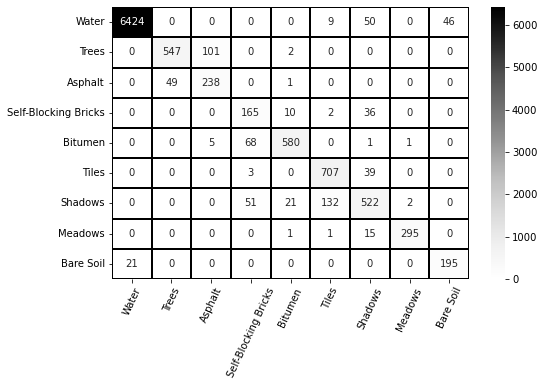

In [35]:
plt.figure(figsize = (8,5))
sns.heatmap(mean_nbcm, annot=True, fmt=".0f", cmap ='Greys',xticklabels=labels_names, yticklabels=labels_names,
           linecolor='k', linewidths=.3)
plt.xticks(rotation=65);